# Лабораторная работа 2: Эллипс

## Вариант 9

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
import warnings

import time

np.set_printoptions(precision=4)

# Task 9

a = 0
b = -2
c = -3

lx = np.pi / 2
ly = np.pi / 2

left_bound   = lambda y : np.exp(-y) * np.cos(y)
right_bound  = lambda y : 0
bottom_bound = lambda x : np.cos(x)
top_bound    = lambda x : 0

analyt_solution = lambda x, y : np.exp(-y) * np.cos(x) * np.cos(y)

# Task 10

a = -2
b = -2
c = -4

lx = np.pi / 2
ly = np.pi / 2

left_bound   = lambda y : np.exp(-y) * np.cos(y)
right_bound  = lambda y : 0
bottom_bound = lambda x : np.exp(-x) * np.cos(x)
top_bound    = lambda x : 0

analyt_solution = lambda x, y : np.exp(-x-y) * np.cos(x) * np.cos(y)

In [2]:
def make_analyt_solution(nx, ny):
        x_step = lx / (nx - 1)
        y_step = ly / (ny - 1)
        grid = np.zeros((nx, ny))
        
        for i in range(nx):
            for j in range(ny):
                grid[i, j] = analyt_solution(x_step * i, y_step * j)
        
        return grid

In [3]:
def solve_liebmann(nx, ny, *, eps):
    def initialize_grid(nx, ny):
        x_step = lx / (nx - 1)
        y_step = ly / (ny - 1)
        grid = np.zeros((nx, ny))

        grid[0,  :] = [left_bound(y_step * j)   for j in range(ny)]
        grid[-1, :] = [right_bound(y_step * j)  for j in range(ny)]
        grid[:,  0] = [bottom_bound(x_step * i) for i in range(nx)]
        grid[:, -1] = [top_bound(x_step * i)    for i in range(nx)]

        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                grid[i, j] = (grid[i, -1] - grid[i, 0]) * j * x_step + grid[i, 0]

        return grid

    def calc_grid_val(u_up, u_left, u_down, u_right, u_mid, h_x, h_y):
        h_x2 = h_x * h_x
        h_y2 = h_y * h_y
        new_val = (
            (-1 * a * h_x * h_y2 / 2 - h_y2) * u_left +
            (     a * h_x * h_y2 / 2 - h_y2) * u_right +
            (-1 * b * h_x2 * h_y / 2 - h_x2) * u_down +
            (     b * h_x2 * h_y / 2 - h_x2) * u_up + 
            h_x2 * h_y2 * c * u_mid
        ) / (-2 * h_y2 - 2 * h_x2)
        
        return new_val
    
    x_step = lx / (nx - 1)
    y_step = ly / (ny - 1)
    grid = initialize_grid(nx, ny)
    
    # Force at least one iteration
    u_max_prev = np.max(np.abs(grid))
    u_max = u_max_prev + eps * 2
    
    while abs(u_max - u_max_prev) >= eps:
        u_max_prev = u_max
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                u_up    = grid[i, j + 1]
                u_down  = grid[i, j - 1]
                u_left  = grid[i - 1, j]
                u_right = grid[i + 1, j]
                u_mid   = grid[i, j]
                grid[i, j] = calc_grid_val(u_up, u_left, u_down, u_right, u_mid, x_step, y_step)
        u_max = np.max(grid[1:-1, 1:-1])

    return grid

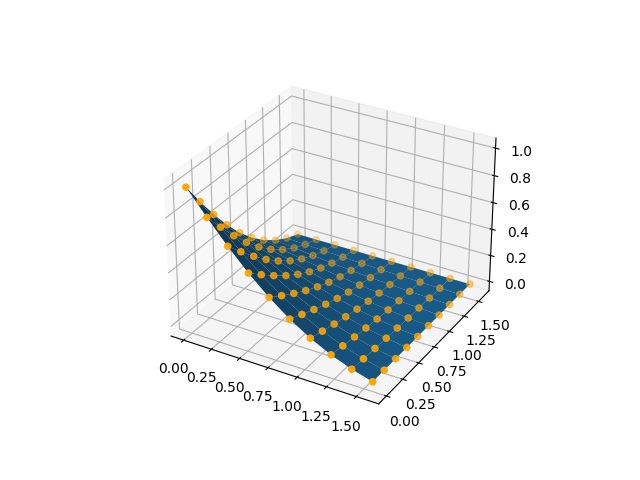

In [4]:
x_count, y_count = 10, 10
grid = solve_liebmann(x_count, y_count, eps=1e-7)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
real_grid = make_analyt_solution(x_count, y_count)
xs, ys = np.meshgrid(np.linspace(0, lx, x_count), np.linspace(0, ly, y_count))

ax.plot_surface(xs, ys, real_grid)
ax.scatter(xs, ys, grid, color='orange')